## Preparing the regression

In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import numpy as np

xr.set_options(display_expand_attrs=False, display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

In [2]:
df_melted = pd.read_csv('df_melted.csv')

### With all variables, on a global level

In [3]:
# Group by time, and equation, and sum the total damage (aggregated data)
df_regression = df_melted.groupby(['time', 'extra_extra_exponent', 'extra_extra_normalisation_constant', 'total_radiative_forcing', 'equation']).sum().reset_index()
df_regression = df_regression.drop( columns=['REGIONS 35 I'])

# Create a dummy for each damage function
df_regression = pd.get_dummies(df_regression, columns=['equation'], drop_first=True)

# Drop the null values
df_regression = df_regression.apply(pd.to_numeric, errors='coerce')
df_regression = df_regression.dropna()


df_regression

,time,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,total_damage,equation_dice_tot_eq_dice_total_impact,equation_witness_tot_eq_witness_total_impact
0,2005.0,-2.499737,37291.354076,1.714491,35.992621,364,23.660000,6.946382e+07,4.609016e+05,2.210159e+05,False,False
1,2005.0,-2.499737,37291.354076,1.714491,35.992621,364,23.660000,6.946382e+07,4.609016e+05,2.669876e+05,True,False
2,2005.0,-2.499737,37291.354076,1.714491,35.992621,364,23.660000,6.946382e+07,4.609016e+05,4.511240e+05,False,True
3,2005.0,-2.483093,48301.730067,1.714491,35.992621,224,23.660000,6.946382e+07,4.609016e+05,2.210159e+05,False,False
4,2005.0,-2.483093,48301.730067,1.714491,35.992621,224,23.660000,6.946382e+07,4.609016e+05,2.669876e+05,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...
2515,2060.0,1.071663,33617.864179,4.301696,30.702805,35,80.555617,7.187911e+08,4.298371e+06,1.373452e+07,True,False
2516,2060.0,1.071663,33617.864179,4.301696,30.702805,35,80.555617,7.187911e+08,4.298371e+06,2.425469e+07,False,True
2517,2060.0,3.259974,18841.706602,4.301696,30.702805,385,80.555617,7.187911e+08,4.298371e+06,2.691910e+07,False,False
2518,2060.0,3.259974,18841.706602,4.301696,30.702805,385,80.555617,7.187911e+08,4.298371e+06,1.373452e+07,True,False


## Checking some hypothesis on the dataset

We want to check the colinearity of our variables. To do so, we compute the correleation matrix, which computes two by two the correlation between multiple variables. We then represent it in the shape of a heatamp.

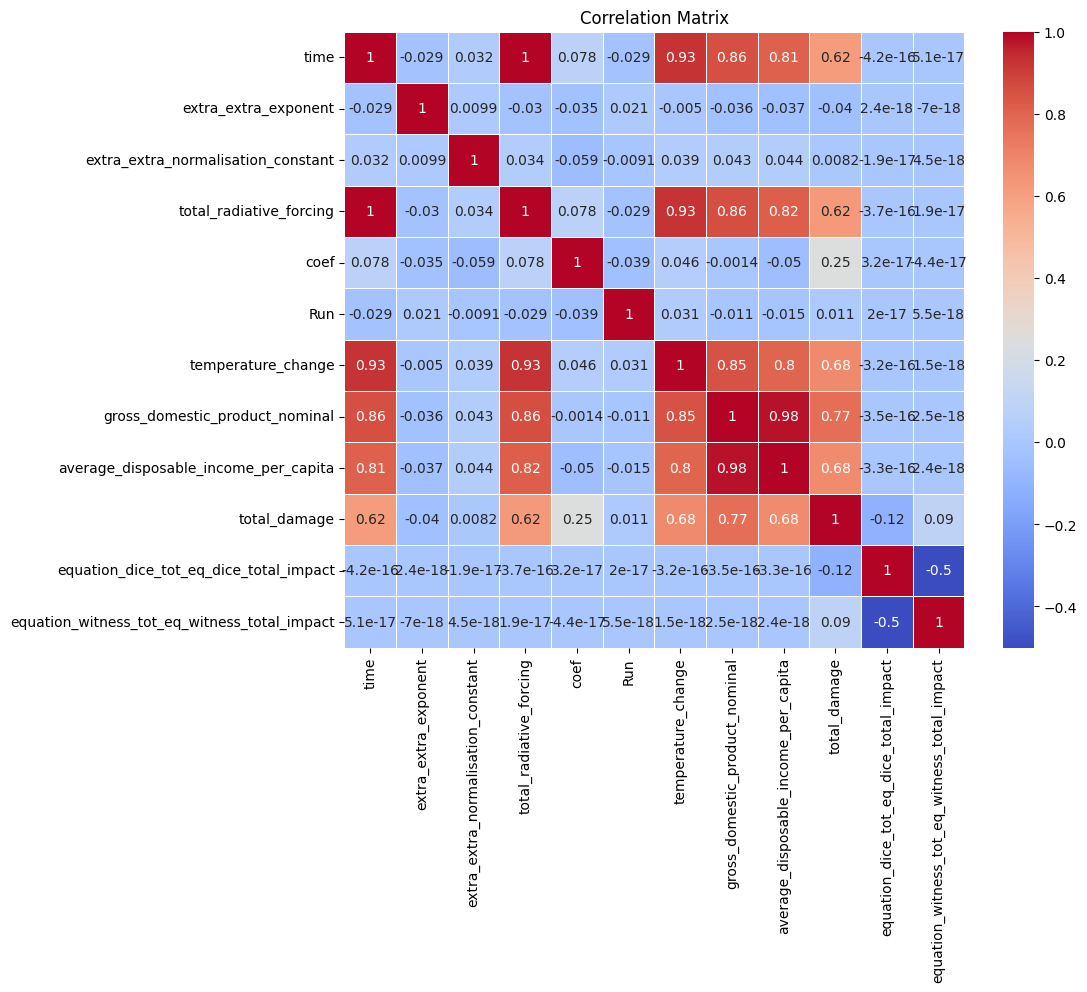

In [4]:
corr_matrix = df_regression.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

We now want to visualize pair plots.

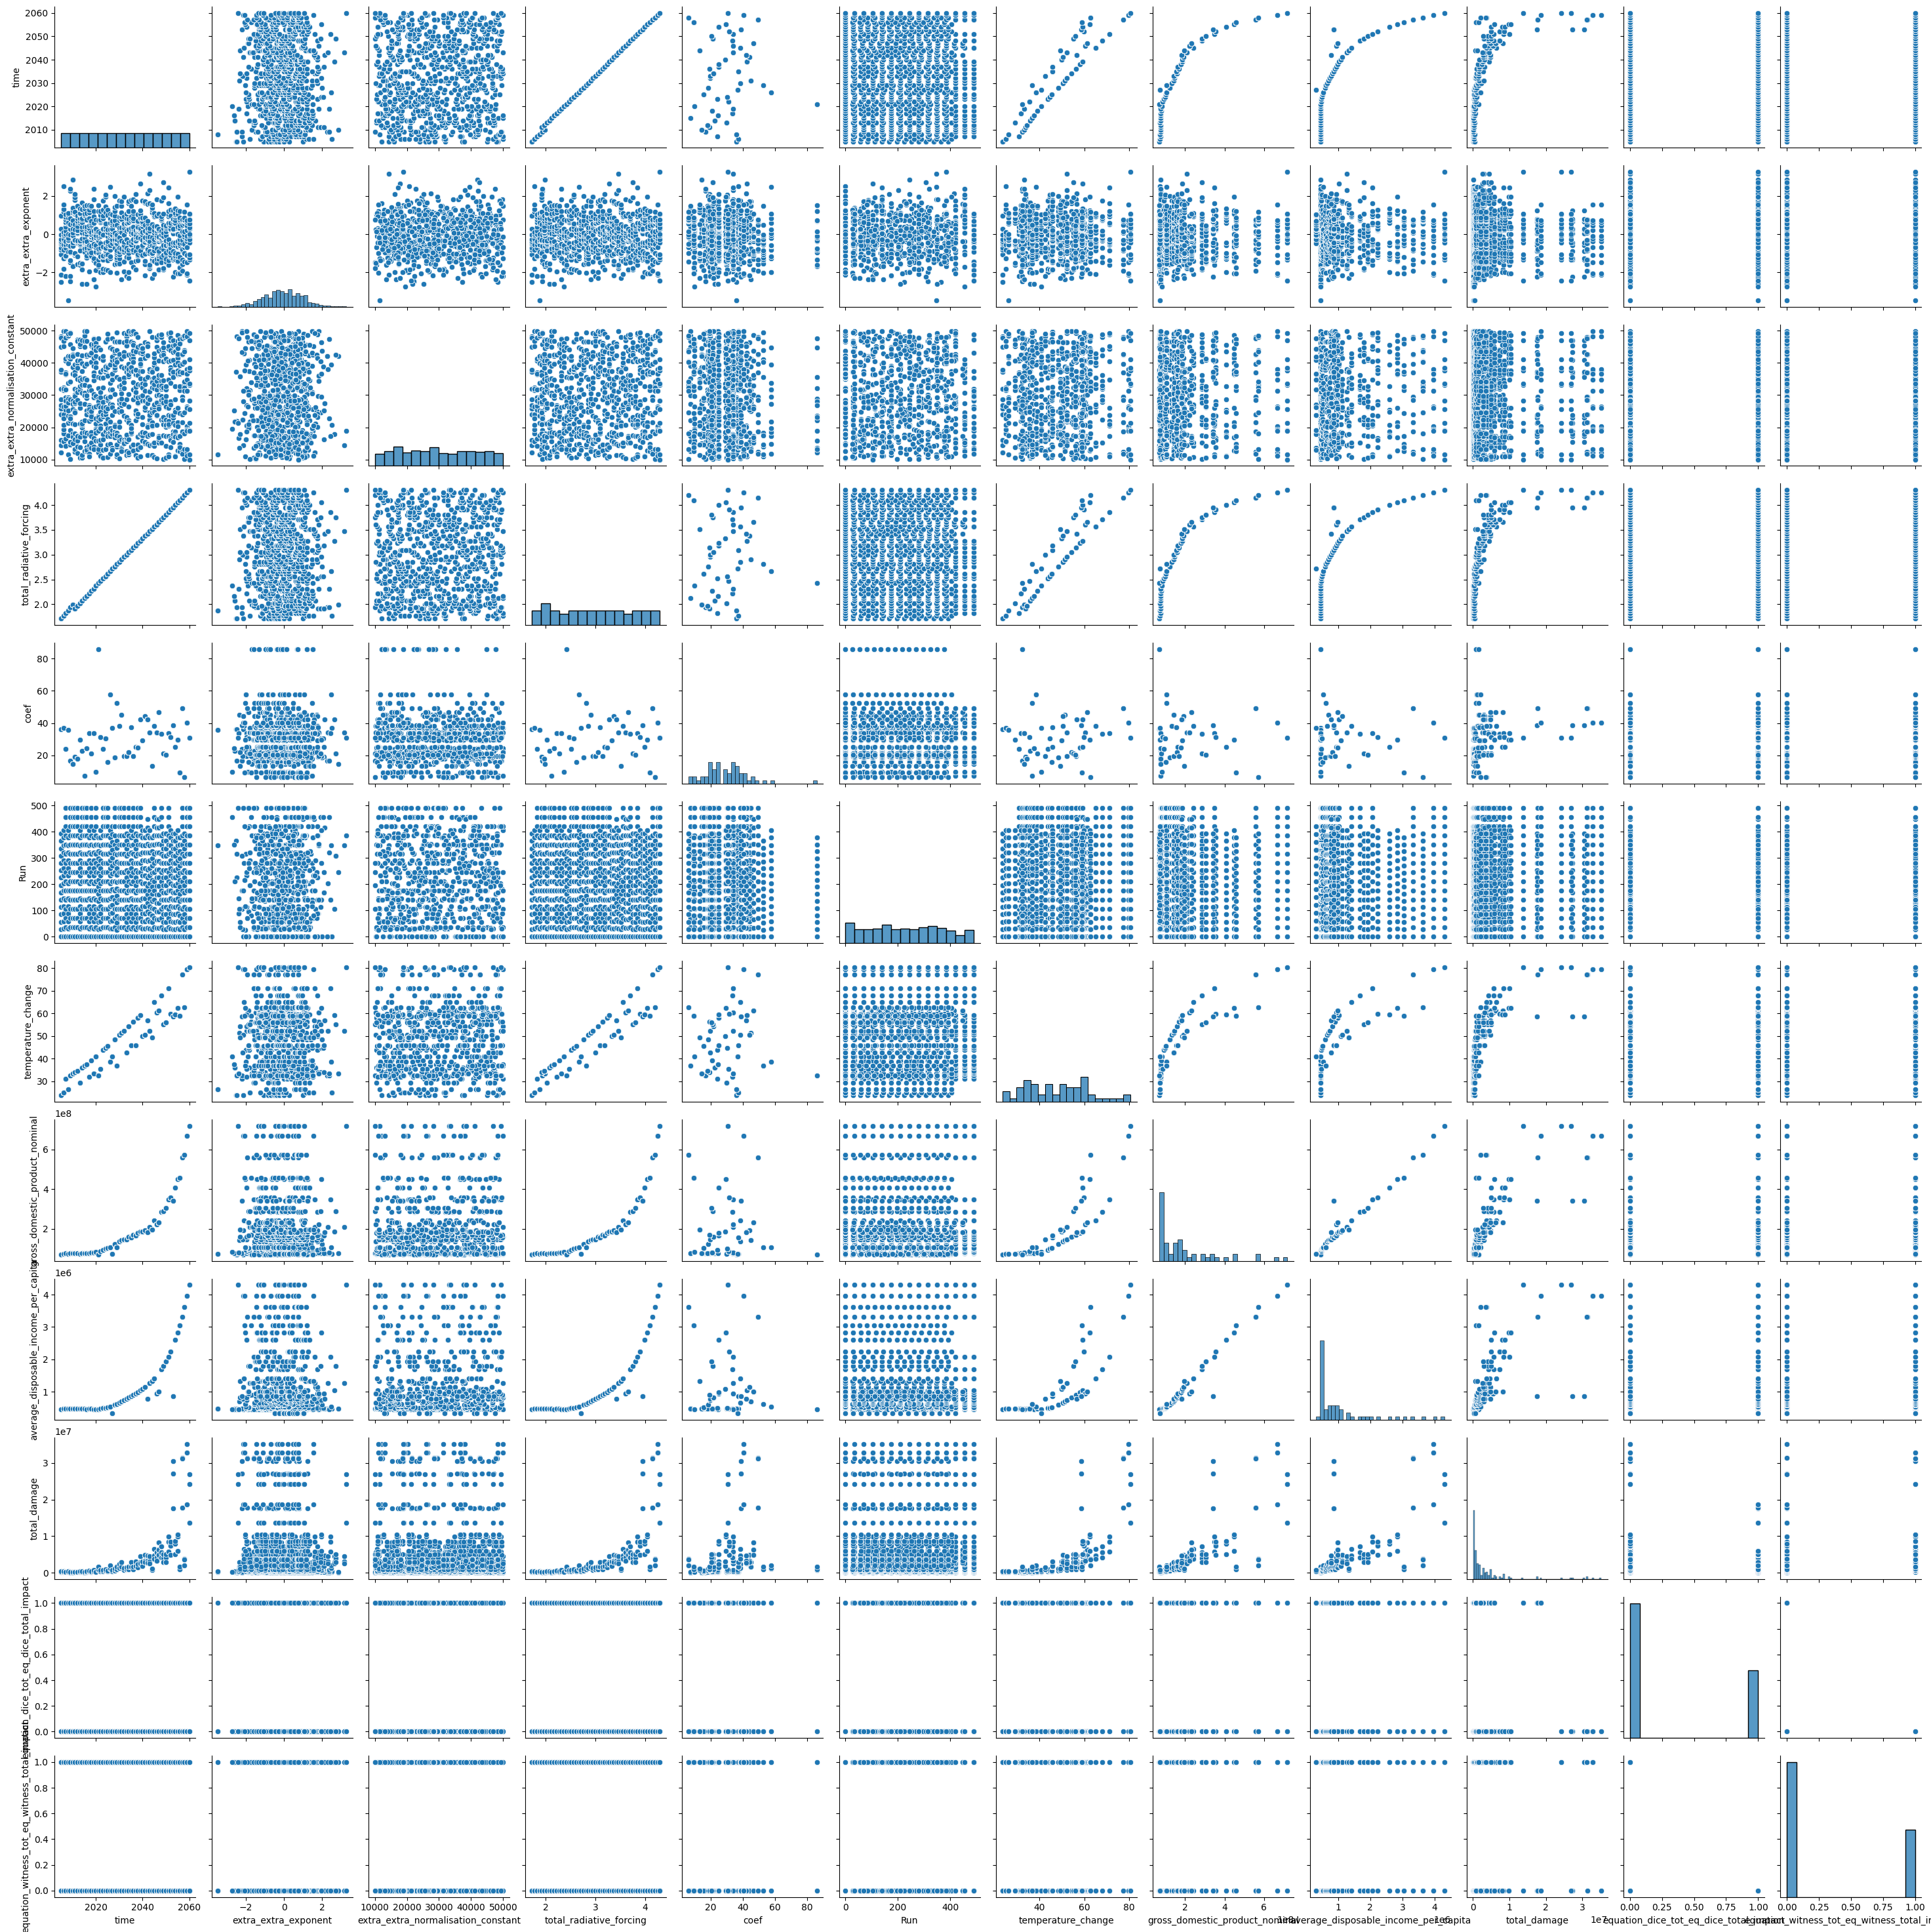

In [5]:
sns.pairplot(df_regression)

If we only do it with variables we have in the regressions : 

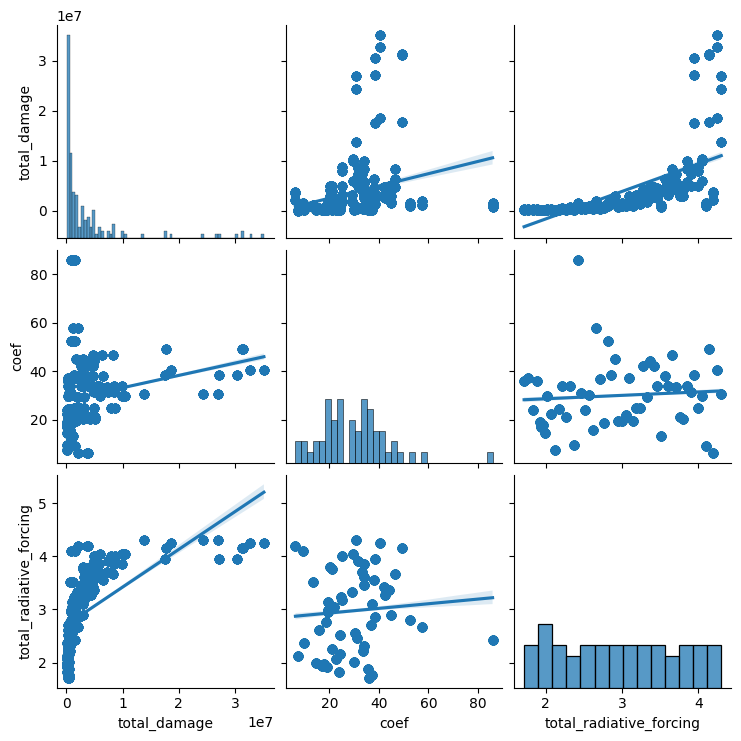

In [6]:
sns.pairplot(df_regression[['total_damage', 'coef', 'total_radiative_forcing']], kind='reg')

Here, I am trying to make the relationship between the radiative forcing and the total damage linear by taking the log of it.

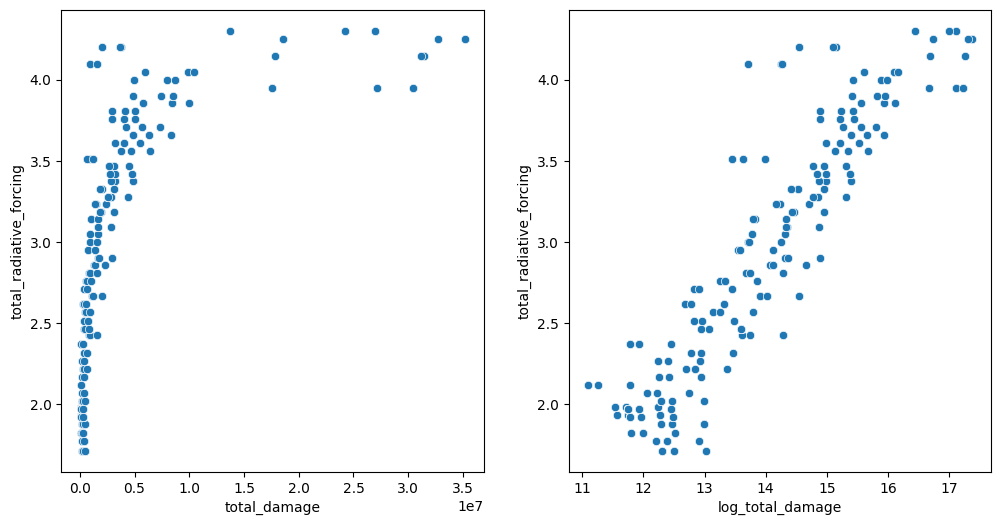

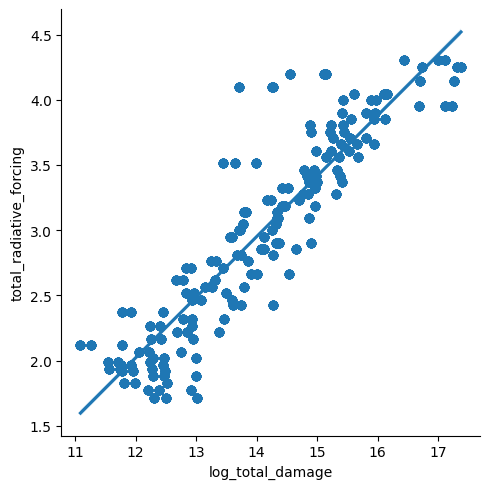

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))



df_regression['log_total_damage'] = np.log(df_regression['total_damage'])
sns.scatterplot(data=df_regression, y='total_radiative_forcing', x='total_damage', ax=ax[0])
sns.scatterplot(data=df_regression, y='total_radiative_forcing', x='log_total_damage', ax=ax[1])

sns.lmplot(data=df_regression, y='total_radiative_forcing', x='log_total_damage')


<Axes: xlabel='extra_extra_normalisation_constant', ylabel='total_damage'>

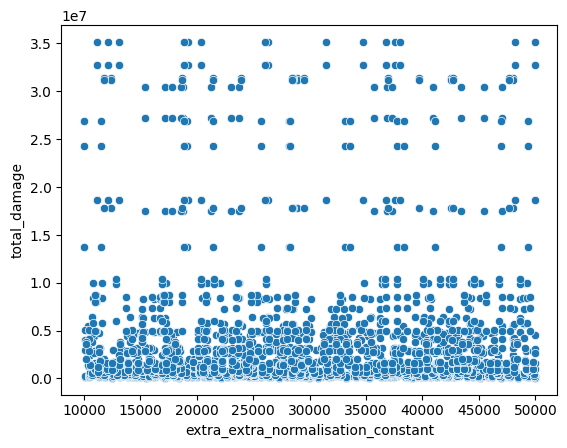

In [8]:
variable = 'extra_extra_normalisation_constant'

sns.scatterplot(data=df_regression, x=variable, y='total_damage')


#### Computing some logs for non-linear relationships

In [9]:
df_log = df_melted.copy()

# Drop negative values
df_log = df_log[df_log['total_damage'] > 0]
df_log = df_log.dropna()

df_log['log_gross_domestic_product_nominal'] = np.log(df_log['gross_domestic_product_nominal'])
df_log['log_temperature_change'] = np.log(df_log['temperature_change'])
df_log['log_coef'] = np.log(df_log['coef']) 


df_log['log_total_damage'] = np.log(df_log['total_damage'])


data = df_log




## Dealing with distribution problems

There is an issue with the data obtained : the distribution of the level of damage is very large, which tends make the regression not working. We try here to fix a few things to make this work. 

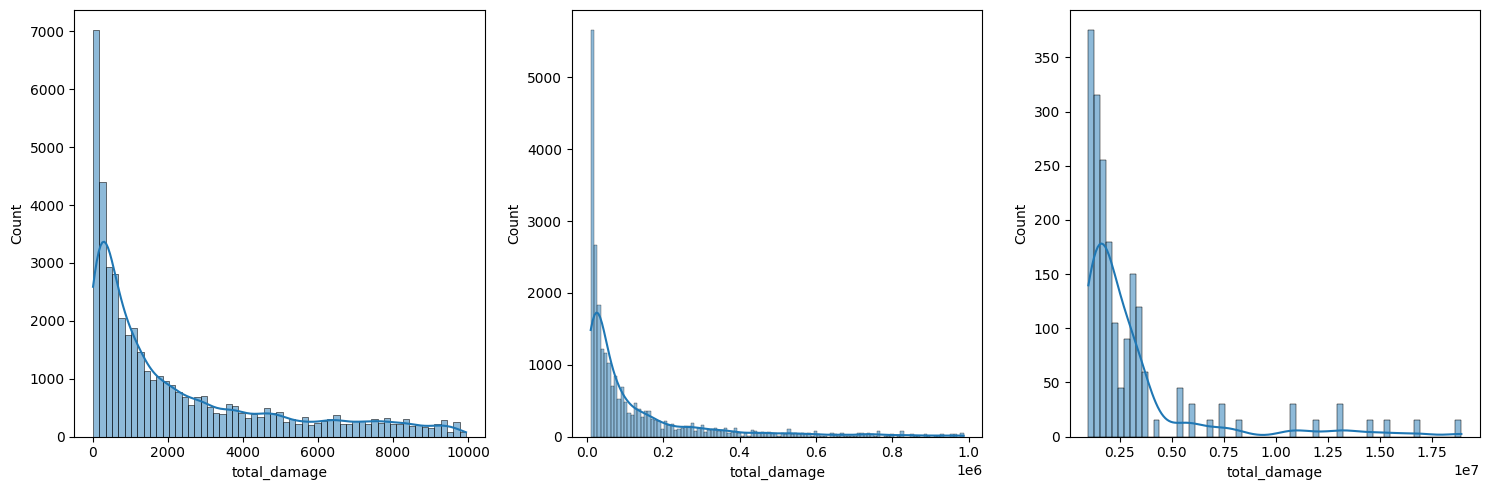

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(data=data[data['total_damage'] < 10000], x='total_damage', kde=True, ax=axes[0])
sns.histplot(data=data[(data['total_damage'] > 10000) & (data['total_damage'] < 1000000)], x='total_damage', kde=True, ax=axes[1])
sns.histplot(data=data[data['total_damage'] > 1000000], x='total_damage', kde=True, ax=axes[2])

plt.tight_layout()
plt.show()

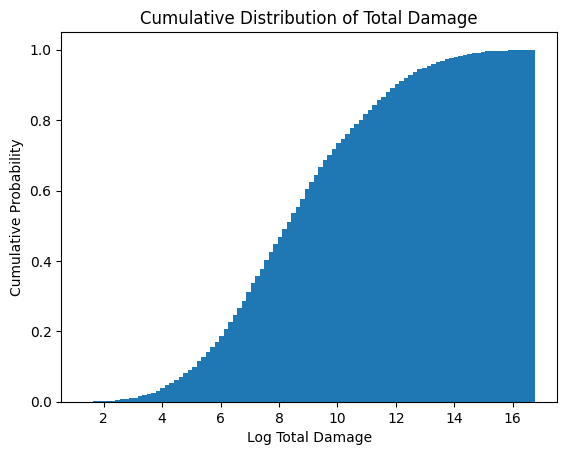

In [11]:
plt.hist(data['log_total_damage'], bins=100, cumulative=True, density=True)
plt.xlabel('Log Total Damage')
plt.ylabel('Cumulative Probability')
plt.title('Cumulative Distribution of Total Damage')
plt.show()

We wish to know which are the outliers, i.e. those with a very high level of damage.

In [26]:
data[data['damage_per_capita'] > 0].groupby('REGIONS 35 I').min()

,time,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,equation,total_damage,log_gross_domestic_product_nominal,log_temperature_change,log_coef,log_total_damage,damage_per_capita
REGIONS 35 I,,,,,,,,,,,,,,,,
BELGIUM,2005.0,-2.593728,10002.171158,1.714491,0.007008,0,0.84500,4.580816e+05,24767.399895,define_tot_eq_define_total_impact,455.259577,13.034803,-0.168419,-4.960736,6.120868,3.217808e-07
BULGARIA,2005.0,-2.593728,10002.171158,1.714491,0.023408,0,0.84500,4.613726e+04,4166.420869,define_tot_eq_define_total_impact,3.738644,10.739376,-0.168419,-3.754669,1.318723,1.361266e-09
CHINA,2005.0,-2.593728,10002.171158,1.714491,0.015134,0,0.84500,1.136377e+07,6214.517573,define_tot_eq_define_total_impact,1490.199415,16.245941,-0.168419,-4.190786,7.306665,1.397530e-06
CROATIA,2005.0,-2.593728,10002.171158,1.714491,0.058584,0,0.84500,4.175639e+04,6431.052414,define_tot_eq_define_total_impact,9.363636,10.639608,-0.168419,-2.837301,2.236834,3.409364e-09
CYPRUS,2005.0,-2.593728,10002.171158,1.714491,0.037169,0,0.84500,1.289871e+04,6489.363442,define_tot_eq_define_total_impact,4.836691,9.464882,-0.168419,-3.292290,1.576231,3.535434e-09
CZECH REPUBLIC,2005.0,-2.593728,10002.171158,1.714491,0.035345,0,0.84500,1.862598e+05,9964.687822,define_tot_eq_define_total_impact,53.937381,12.134898,-0.168419,-3.342605,3.987824,1.963897e-08
DENMARK,2005.0,-2.593728,10002.171158,1.714491,0.006719,0,0.84500,2.966163e+05,28613.689785,define_tot_eq_define_total_impact,251.554512,12.600195,-0.168419,-5.002799,5.527660,1.614261e-07
EASOC,2005.0,-2.593728,10002.171158,1.714491,0.058830,0,0.84500,1.002080e+07,8408.316150,define_tot_eq_define_total_impact,2282.842002,16.120173,-0.168419,-2.833109,7.733176,8.311983e-07
ESTONIA,2005.0,-2.593728,10002.171158,1.714491,0.036888,0,0.84500,2.245068e+04,9335.545650,define_tot_eq_define_total_impact,5.959295,10.019076,-0.168419,-3.299882,1.784952,2.169820e-09


<Axes: xlabel='time', ylabel='total_damage'>

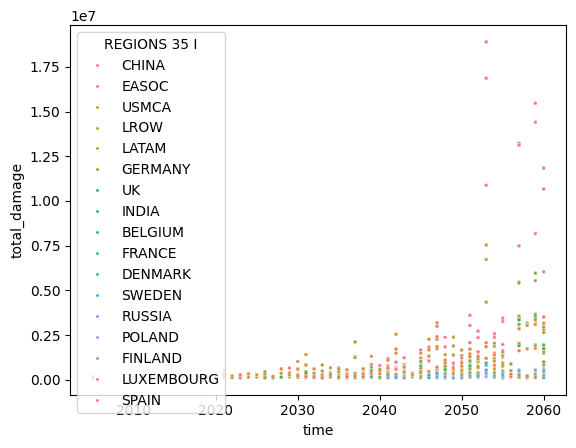

In [13]:
sns.scatterplot(data=data[data['total_damage'] > 100000], x='time', y='total_damage', hue='REGIONS 35 I', s=5)

Mainly very rich or very populated areas appear as very large damage countries; this makes sense, as regions from the WILIAM model are very heterogeneous. However, this is not the effect we want to measure. Hence, we want to normalize by the population. 

In [31]:
pop_region = pd.read_csv('geography\\grouped_base_map.csv')
pop_region

,WILIAM code,pop_est
0,China,1.397715e+09
1,EASOC,8.772323e+08
2,EU27,4.555853e+08
3,India,1.366418e+09
4,LATAM,3.628377e+08
5,LROW,2.746447e+09
6,Russia,1.443735e+08
7,UK,6.683440e+07
8,USMCA,4.934043e+08


In [30]:
data.merge(pop_region, left_on='REGIONS 35 I', right_on='WILIAM code')
data.head()

,time,REGIONS 35 I,extra_extra_exponent,extra_extra_normalisation_constant,total_radiative_forcing,coef,Run,temperature_change,gross_domestic_product_nominal,average_disposable_income_per_capita,equation,total_damage,log_gross_domestic_product_nominal,log_temperature_change,log_coef,log_total_damage,damage_per_capita
0,2005.0,BELGIUM,-2.120837,14345.919289,1.714491,0.484972,0,0.845,458081.623996,24767.399895,define_tot_eq_define_total_impact,455.259577,13.034803,-0.168419,-0.723664,6.120868,6.811755e-06
1,2005.0,BULGARIA,-2.120837,14345.919289,1.714491,3.328578,0,0.845,49342.067424,4290.060541,define_tot_eq_define_total_impact,336.570307,10.806532,-0.168419,1.202545,5.818807,3.836730e-07
2,2005.0,CROATIA,-2.120837,14345.919289,1.714491,1.784685,0,0.845,49378.731850,7565.730576,define_tot_eq_define_total_impact,180.593082,10.807275,-0.168419,0.579242,5.196246,4.977241e-07
3,2005.0,CYPRUS,-2.120837,14345.919289,1.714491,0.828186,0,0.845,20251.576648,15217.411656,define_tot_eq_define_total_impact,34.370532,9.915988,-0.168419,-0.188518,3.537200,6.965997e-08
4,2005.0,CZECH REPUBLIC,-2.120837,14345.919289,1.714491,1.306405,0,0.845,186259.756742,10050.031677,define_tot_eq_define_total_impact,498.650910,12.134898,-0.168419,0.267279,6.211906,1.815622e-07


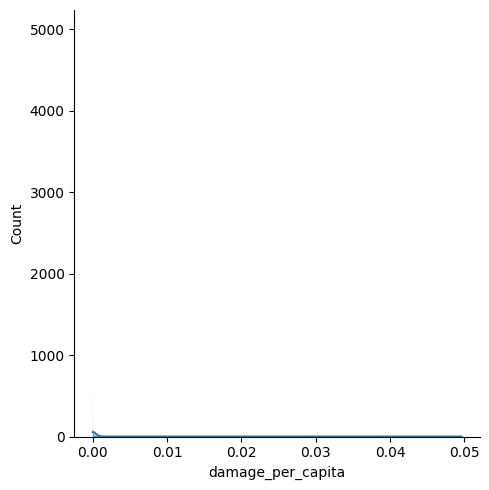

In [17]:
data['damage_per_capita'] = data['total_damage'] / data.merge(pop_region, left_on='REGIONS 35 I', right_on='WILIAM code')['pop_est']
sns.displot(data=data, x='damage_per_capita', kde=True)

In [16]:
# Saving data for the regression notebook
data.to_csv('data.csv', index=False)